## Classical Flow Matching
Implementing a classical flow matching model to compare to the quantum model, which ended up being diffusion/flow matching inspired.

Heavily inspired by: [Flow Matching on MNIST](https://github.com/seichang00/flow-matching-lightning).

In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

import os
import math
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = "fm_outputs"
os.makedirs(out_dir, exist_ok=True)

batch_size = 32
epochs = 10
lr = 1e-3
image_size = 28
channels = 1
latent_std = 1.0  # standard deviation for gaussian prior
save_every = 10
subset_size = 10000  # Set to None to use full dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),               # 0-1
    transforms.Normalize((0.5,), (0.5,)) # map to [-1, 1]
])
train_ds = datasets.MNIST(root="./mnist", train=True, download=False, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

if subset_size is not None:
    train_ds = torch.utils.data.Subset(train_ds, range(subset_size))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.SiLU(),
            nn.Linear(dim*4, dim)
        )

    def forward(self, t):
        # sinusoidal embedding (like transformer / diffusion)
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)  # (B, half)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)
    
class SmallConvField(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=32):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)

        self.init_conv = nn.Conv2d(in_ch + 1, base_ch, kernel_size=3, padding=1) # +1 channel for time broadcast
        self.down1 = nn.Conv2d(base_ch, base_ch, kernel_size=3, padding=1)
        self.down2 = nn.Conv2d(base_ch, base_ch, kernel_size=3, padding=1)

        self.mid = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, kernel_size=3, padding=1),
            nn.SiLU()
        )

        # inject time embedding to final layers via broadcasting and addition
        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, kernel_size=3, padding=1)  # predict same-channel vector field
        )

        self.time_proj = nn.Linear(time_emb_dim, base_ch)

    def forward(self, x, t):
        """
        x: (B, C, H, W) where C=1 (image)
        t: (B,) in [0,1]
        returns v(x,t) shape same as x
        """
        B, C, H, W = x.shape
        # broadcast time as an extra channel (scalar per image)
        t_channel = t.view(B, 1, 1, 1).expand(-1, 1, H, W)
        xt = torch.cat([x, t_channel], dim=1)  # (B, C+1, H, W)
        h = self.init_conv(xt)
        h = F.silu(self.down1(h) + h)
        h = F.silu(self.down2(h) + h)

        h = self.mid(h)
        # time embedding projection and add
        t_emb = self.time_emb(t)             # (B, time_emb_dim)
        t_proj = self.time_proj(t_emb)       # (B, base_ch)
        t_proj = t_proj.view(B, -1, 1, 1)    # (B, base_ch, 1, 1)
        h = h + t_proj

        out = self.final(h)
        return out

In [5]:
def linear_mix(x0, x1, t):
    # x_t = (1 - t) * x0 + t * x1
    return (1.0 - t.view(-1,1,1,1)) * x0 + t.view(-1,1,1,1) * x1

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)  # x0: (B,1,28,28) in [-1,1]
        B = imgs.shape[0]

        # sample random prior images x1 ~ N(0, I)
        x1 = torch.randn_like(imgs) * latent_std

        # sample t uniformly in [0,1)
        t = torch.rand(B, device=device)

        # construct x_t
        x_t = linear_mix(imgs, x1, t)

        # target vector field: dx_t/dt = x1 - x0 (constant for linear interpolation)
        target_v = (x1 - imgs)

        # predict v(x_t, t)
        pred_v = model(x_t, t)

        loss = F.mse_loss(pred_v, target_v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(loader.dataset)

@torch.no_grad()
def rk4_integration(model, x_init, t0=1.0, t1=0.0, steps=50):
    """
    Integrate dx/dt = v(x, t) from t0 -> t1 using RK4
    x_init: (B, C, H, W) initial states at time t0
    returns x_final at t1
    """
    model.eval()
    x = x_init.clone()
    B = x.shape[0]
    t0 = float(t0)
    t1 = float(t1)
    dt = (t1 - t0) / steps  # negative if t1 < t0

    t = t0
    for i in range(steps):
        t_tensor = torch.full((B,), t, device=x.device)
        k1 = model(x, t_tensor)
        k2 = model(x + 0.5 * dt * k1, t_tensor + 0.5 * dt)
        k3 = model(x + 0.5 * dt * k2, t_tensor + 0.5 * dt)
        k4 = model(x + dt * k3, t_tensor + dt)
        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
    return x

def sample_and_save(model, epoch, n=64, steps=80):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, channels, image_size, image_size, device=device) * latent_std  # sample from prior at t=1
        x = rk4_integration(model, z, t0=1.0, t1=0.0, steps=steps)
        # map back from [-1,1] to [0,1] for visualization
        imgs = (x.clamp(-1,1) + 1.0) / 2.0
        grid = utils.make_grid(imgs, nrow=int(math.sqrt(n)), pad_value=1.0)
        save_path = os.path.join(out_dir, f"samples_epoch_{epoch}.png")
        utils.save_image(grid, save_path)
        print(f"Saved samples to {save_path}")
        return imgs

Epoch 1: 100%|██████████| 312/312 [03:04<00:00,  1.69it/s, loss=0.252]


Epoch 1 average loss: 0.434437


Epoch 2: 100%|██████████| 312/312 [03:12<00:00,  1.62it/s, loss=0.263]


Epoch 2 average loss: 0.266787


Epoch 3: 100%|██████████| 312/312 [02:44<00:00,  1.89it/s, loss=0.226]


Epoch 3 average loss: 0.242156


Epoch 4: 100%|██████████| 312/312 [02:32<00:00,  2.05it/s, loss=0.24] 


Epoch 4 average loss: 0.236638


Epoch 5: 100%|██████████| 312/312 [03:12<00:00,  1.62it/s, loss=0.281]


Epoch 5 average loss: 0.229583


Epoch 6: 100%|██████████| 312/312 [02:55<00:00,  1.78it/s, loss=0.22] 


Epoch 6 average loss: 0.224441


Epoch 7: 100%|██████████| 312/312 [01:54<00:00,  2.73it/s, loss=0.204]


Epoch 7 average loss: 0.224405


Epoch 8: 100%|██████████| 312/312 [02:45<00:00,  1.89it/s, loss=0.235]


Epoch 8 average loss: 0.229576


Epoch 9: 100%|██████████| 312/312 [02:49<00:00,  1.84it/s, loss=0.216]


Epoch 9 average loss: 0.220824


Epoch 10: 100%|██████████| 312/312 [03:04<00:00,  1.69it/s, loss=0.211]


Epoch 10 average loss: 0.222176
Saved samples to fm_outputs\samples_epoch_10.png
Saved model checkpoint.


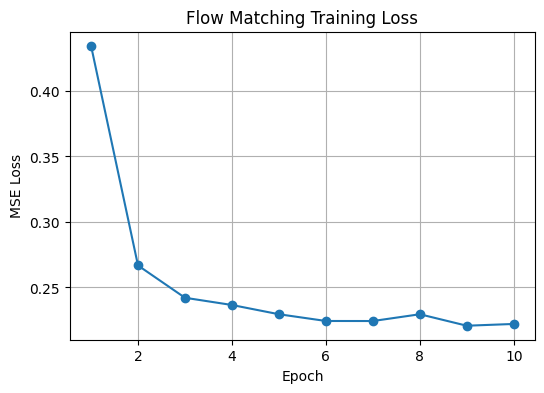

In [6]:
model = SmallConvField(in_ch=channels, base_ch=64, time_emb_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    loss_history.append(train_loss)
    print(f"Epoch {epoch} average loss: {train_loss:.6f}")

    if epoch % save_every == 0 or epoch == epochs:
        sample_and_save(model, epoch, n=64, steps=100)
        torch.save(model.state_dict(), os.path.join(out_dir, f"model_epoch_{epoch}.pth"))
        print("Saved model checkpoint.")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Flow Matching Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()